In [77]:
# 분석 라이브러리
import numpy as np 
import pandas as pd
import random as rnd
# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [78]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [79]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

train 결측치: age(탑승자 나이), cabin(객실 번호), Embarked(배에 탑승한 항구이름)
test 결측치: age, Fare(요금), cabin

In [80]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [81]:
# 일단 이름과 Ticket은 상관 없을 것 같아서 삭제

train = train.drop(['Name','Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)

In [82]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


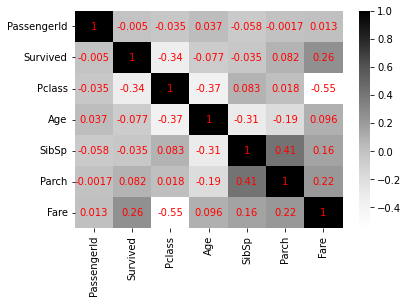

In [83]:
train_corr = train.corr()
ax = sns.heatmap(train_corr, annot=True, annot_kws=dict(color='r'), cmap='Greys')
plt.show()

나이 결측치를 채워야 하는데, 이때 Age와 가장 corr가 높은 Pclass를 이용하여 채우자

In [84]:
# Pclass등급에 따른 나이 평균을 정리해봐서, 이를 바탕으로 나이 결측값 채워보려 함

train.pivot_table(values = 'Age', index = 'Pclass', aggfunc = 'mean')

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


In [85]:
# 결측값을 가지는 새로운 데이터 프레임 생성

train_age_null = train[train.Age.isnull()]
train_age_null

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
5,6,0,3,male,NaN,0,0,8.4583,NaN,Q
17,18,1,2,male,NaN,0,0,13.0000,NaN,S
19,20,1,3,female,NaN,0,0,7.2250,NaN,C
26,27,0,3,male,NaN,0,0,7.2250,NaN,C
28,29,1,3,female,NaN,0,0,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,male,NaN,0,0,7.2292,NaN,C
863,864,0,3,female,NaN,8,2,69.5500,NaN,S
868,869,0,3,male,NaN,0,0,9.5000,NaN,S
878,879,0,3,male,NaN,0,0,7.8958,NaN,S


In [86]:
# 각 데이터를 1,2,3 등급에 나눠서 각 테이블의 각 결측값 채우자

firstclass = train_age_null[train_age_null['Pclass'] == 1]
secondclass = train_age_null[train_age_null['Pclass'] == 2]
thirdclass = train_age_null[train_age_null['Pclass'] == 3]

In [87]:
# 각 테이블에 결측값 채우기

firstclass = firstclass.fillna(38)
secondclass = secondclass.fillna(30)
thirdclass = thirdclass.fillna(25)

In [88]:
# 원래 데이터에 위해서 구한 값들 넣기 위해서 age 결측치 포함하는 행 삭제

train_dropna = train.dropna(subset = ['Age'])

In [89]:
# 위해서 구한 값들과 합쳐주자

train_concat = pd.concat([train_dropna, firstclass, secondclass, thirdclass])
train = train_concat
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 888
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        362 non-null    object 
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.6+ KB


In [90]:
test_age_null = test[test.Age.isnull()]
# 결측값을 가지는 새로운 데이터 프레임을 생성한다.

# train_df.loc[train_df.Age.isnull() == True]&train_df
# 각 데이터를 1,2,3등급에 나누어서 
test_firstclass = test_age_null[test_age_null.Pclass == 1]
test_second = test_age_null[test_age_null.Pclass == 2]
test_third = test_age_null[test_age_null.Pclass == 3]

test_firstclass = test_firstclass.fillna(value = '38')
test_secondclass = test_second.fillna(value = '30')
test_thirdclass = test_third.fillna(value = '25')

# Age의 결측값을 포함하는 행을 삭제한다.
test_drop_na = test.dropna(subset = ['Age'])

#결측값을 제거한 테이블과 결측값을 포함하지 않는 테이블을 병합한다.
test_concat = pd.concat([test_drop_na, test_firstclass, test_secondclass, test_thirdclass])
test = test_concat

train_df = train_df.astype({'Age':'int'}) 

이거로 데이터 타입 변경 가능

In [91]:
train['Embarked'].value_counts()

# S가 다수니까 Embarked 결측치 S로 채우고자 함

train["Embarked"].fillna('S', inplace=True)
test["Embarked"].fillna('S', inplace=True)

pd.DataFrame.mean(train['Fare'])

32.20420796857454

Fare 값의 평균이 32.20420이니, 이로 test 결측치 채워주자

In [92]:
test['Fare'].fillna(32.2042, inplace=True)

Sex 더미변수니까 0, 1로 변환

In [93]:

train['Sex'] = train['Sex'].replace('male',0)
test['Sex'] = test['Sex'].replace('male',0)

train['Sex'] = train['Sex'].replace('female',1)
test['Sex'] = test['Sex'].replace('female',1)

In [94]:
# Embarked에서 변수 숫자로 변환

train.loc[train['Embarked'] == 'C','Embarked'] = 0
train.loc[train['Embarked'] == 'Q','Embarked'] = 1
train.loc[train['Embarked'] == 'S','Embarked'] = 2

test.loc[test['Embarked'] == 'C','Embarked'] = 0
test.loc[test['Embarked'] == 'Q','Embarked'] = 1
test.loc[test['Embarked'] == 'S','Embarked'] = 2

train['Embarked'] = train['Embarked'].astype(int)
test['Embarked'] = test['Embarked'].astype(int)

Cabin(객실번호), Passengerld(고객 아이디)도 안쓸거 같으니까 그냥 drop

In [95]:
train = train.drop(['Cabin','PassengerId'], axis=1)
test = test.drop(['Cabin','PassengerId'], axis=1)

In [96]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int32  
dtypes: float64(2), int32(1), int64(5)
memory usage: 59.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    object 
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null  

In [99]:
x_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']
x_test = test
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,2
1,1,1,38.0,1,0,71.2833,0
2,3,1,26.0,0,0,7.9250,2
3,1,1,35.0,1,0,53.1000,2
4,3,0,35.0,0,0,8.0500,2


In [100]:
RF = RandomForestClassifier(n_estimators = 100)
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)
RF.score(x_train, y_train)

0.9809203142536476

In [101]:
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
svc.score(x_train, y_train)

0.6835016835016835

In [102]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
knn.score(x_train, y_train)

0.8439955106621774

In [104]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

KeyError: 'PassengerId'